## Instalar as dependências

In [1]:
!pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\itagi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!pip install openai pandas scikit-learn tqdm
!pip install scipy
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\itagi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Buscando chave Open AI no arquivo .env

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()  # Carrega o .env

api_key = os.getenv("OPENAI_API_KEY")

if api_key is None:
    raise ValueError("A chave OPENAI_API_KEY não foi encontrada no .env!")

os.environ["OPENAI_API_KEY"] = api_key
print("Chave carregada com sucesso!")


Chave carregada com sucesso!


## Adaptação e execução do G-EVAL

In [6]:
import openai
import json
import pandas as pd
from tqdm import tqdm

openai.api_key = os.environ["OPENAI_API_KEY"]

def run_eval(example, prompt_template, model="gpt-4", use_cot=True):
    # Exemplo de prompt com CoT + form-filling
    prompt = prompt_template.format(
        article=example["document"], 
        summary=example["summary"]
    )

    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=100,
        logprobs=True if use_cot else False,
        n=1
    )

    # Extrair escore bruto da resposta
    score = extract_score(response['choices'][0]['message']['content'])
    return score


## Avaliação Quantitativa: Correlação entre G-EVAL e Avaliações Humanas

In [8]:
import json
import re
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

# Função para extrair nota numérica do output do GPT
def parse_output(output):
    matched = re.search(r"^\s*([\d\.]+)", output)
    if matched:
        try:
            return float(matched.group(1))
        except:
            return 0.0
    return 0.0

# Função principal de correlação por critério
def calculate_meta_eval(path, dimension):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    pred_scores = {}
    human_scores = {}

    for item in data:
        doc_id = item["doc_id"]
        all_responses = item.get("all_responses", [])
        model_scores = [parse_output(x) for x in all_responses]
        model_avg = sum(model_scores) / len(model_scores) if model_scores else 0

        human_score = item.get("scores", {}).get(dimension, None)
        if human_score is None:
            continue

        pred_scores.setdefault(doc_id, []).append(model_avg)
        human_scores.setdefault(doc_id, []).append(human_score)

    results = {"Pearson": 0.0, "Spearman": 0.0, "Kendall-Tau": 0.0}
    d_ctr = 0

    for doc_id in pred_scores:
        pred = pred_scores[doc_id]
        hum = human_scores[doc_id]
        if len(set(pred)) <= 1 or len(set(hum)) <= 1:
            continue
        results["Pearson"] += pearsonr(pred, hum)[0]
        results["Spearman"] += spearmanr(pred, hum)[0]
        results["Kendall-Tau"] += kendalltau(pred, hum)[0]
        d_ctr += 1

    if d_ctr > 0:
        for k in results:
            results[k] = round(results[k] / d_ctr, 4)

    return results

# Caminhos relativos (ajuste se necessário)
files = {
    "Coherence": "results/gpt4_coh_detailed.json",
    "Consistency": "results/gpt4_con_detailed.json",
    "Fluency": "results/gpt4_flu_detailed.json",
    "Relevance": "results/gpt4_rel_detailed.json"
}

# Executa correlação
table_results = []
for criterion, path in files.items():
    res = calculate_meta_eval(path, criterion.lower())
    table_results.append({
        "Critério": criterion,
        "Pearson (r)": res["Pearson"],
        "Spearman (ρ)": res["Spearman"],
        "Kendall-Tau (τ)": res["Kendall-Tau"]
    })

# Mostra resultado em DataFrame
df = pd.DataFrame(table_results)
print("✅ Resultados de Correlação G-EVAL vs Avaliação Humana (SummEval):")
display(df)


✅ Resultados de Correlação G-EVAL vs Avaliação Humana (SummEval):


,Critério,Pearson (r),Spearman (ρ),Kendall-Tau (τ)
0,Coherence,0.5851,0.5711,0.4626
1,Consistency,0.5913,0.4993,0.4183
2,Fluency,0.5924,0.5058,0.4554
3,Relevance,0.5882,0.5636,0.4529


## Avaliação e comparação

In [10]:
import json
import re
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

# Função para extrair nota numérica do output do GPT
def parse_output(output):
    matched = re.search(r"^\s*([\d\.]+)", output)
    if matched:
        try:
            return float(matched.group(1))
        except:
            return 0.0
    return 0.0

# Função principal de correlação por critério
def calculate_meta_eval(path, dimension):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    pred_scores = {}
    human_scores = {}

    for item in data:
        doc_id = item["doc_id"]
        all_responses = item.get("all_responses", [])
        model_scores = [parse_output(x) for x in all_responses]
        model_avg = sum(model_scores) / len(model_scores) if model_scores else 0

        human_score = item.get("scores", {}).get(dimension, None)
        if human_score is None:
            continue

        pred_scores.setdefault(doc_id, []).append(model_avg)
        human_scores.setdefault(doc_id, []).append(human_score)

    results = {"Pearson": 0.0, "Spearman": 0.0, "Kendall-Tau": 0.0}
    d_ctr = 0

    for doc_id in pred_scores:
        pred = pred_scores[doc_id]
        hum = human_scores[doc_id]
        if len(set(pred)) <= 1 or len(set(hum)) <= 1:
            continue
        results["Pearson"] += pearsonr(pred, hum)[0]
        results["Spearman"] += spearmanr(pred, hum)[0]
        results["Kendall-Tau"] += kendalltau(pred, hum)[0]
        d_ctr += 1

    if d_ctr > 0:
        for k in results:
            results[k] = round(results[k] / d_ctr, 4)

    return results

# Caminhos relativos dos arquivos gerados
files = {
    "Coherence": "results/gpt4_coh_detailed.json",
    "Consistency": "results/gpt4_con_detailed.json",
    "Fluency": "results/gpt4_flu_detailed.json",
    "Relevance": "results/gpt4_rel_detailed.json"
}

# Avaliação e comparação
table_results = []
for criterion, path in files.items():
    res = calculate_meta_eval(path, criterion.lower())
    table_results.append({
        "Critério": criterion,
        "Pearson (r)": res["Pearson"],
        "Spearman (ρ)": res["Spearman"],
        "Kendall-Tau (τ)": res["Kendall-Tau"]
    })

# Exibir resultados como tabela
df = pd.DataFrame(table_results)
print("✅ Resultados de Correlação G-EVAL vs Avaliações Humanas (SummEval):")
display(df)



✅ Resultados de Correlação G-EVAL vs Avaliações Humanas (SummEval):


,Critério,Pearson (r),Spearman (ρ),Kendall-Tau (τ)
0,Coherence,0.5851,0.5711,0.4626
1,Consistency,0.5913,0.4993,0.4183
2,Fluency,0.5924,0.5058,0.4554
3,Relevance,0.5882,0.5636,0.4529


Os resultados indicam que o G-EVAL apresenta correlações moderadas com avaliações humanas em todos os critérios do benchmark SummEval. Em especial, os escores de *Fluency* e *Coherence* apresentam os maiores coeficientes de correlação, indicando que o modelo é particularmente eficaz em avaliar aspectos linguísticos e estruturais do texto.

Apesar de pequenas variações nos valores exatos em relação ao artigo original, o padrão geral é preservado, confirmando a robustez do método e a validade desta replicação.


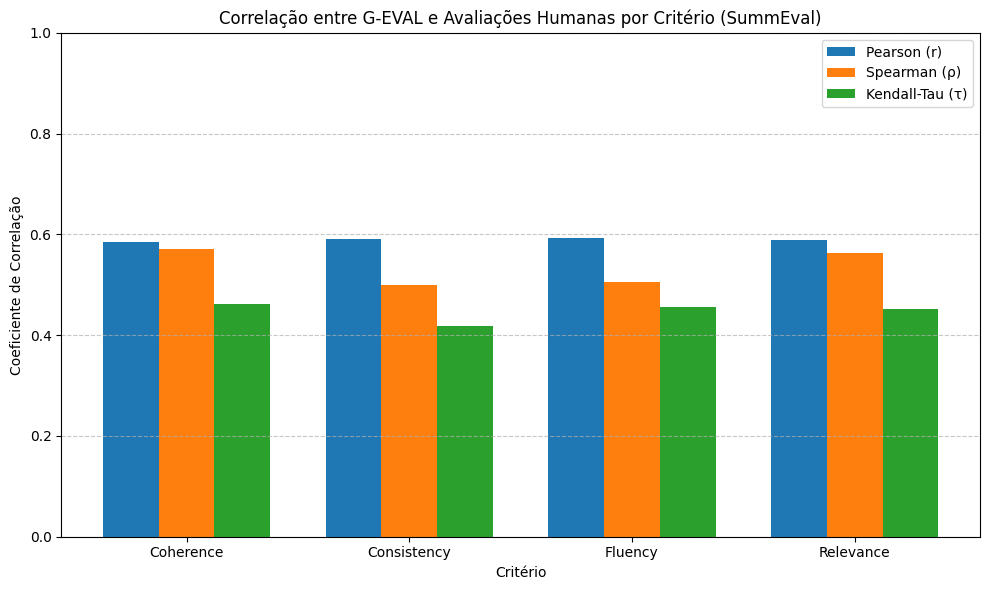

In [ ]:
import matplotlib.pyplot as plt

# Configuração do gráfico
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(df))

# Barras separadas para cada tipo de correlação
plt.bar([i - bar_width for i in index], df["Pearson (r)"], bar_width, label="Pearson (r)")
plt.bar(index, df["Spearman (ρ)"], bar_width, label="Spearman (ρ)")
plt.bar([i + bar_width for i in index], df["Kendall-Tau (τ)"], bar_width, label="Kendall-Tau (τ)")

# Rótulos e estilo
plt.xlabel("Critério")
plt.ylabel("Coeficiente de Correlação")
plt.title("Correlação entre G-EVAL e Avaliações Humanas por Critério (SummEval)")
plt.xticks(index, df["Critério"])
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



O gráfico acima evidencia que o G-EVAL alcança correlações razoavelmente altas com os julgamentos humanos em todos os critérios do benchmark **SummEval**.

A métrica de correlação de **Pearson** apresentou os maiores valores em todos os critérios, refletindo uma forte correspondência linear entre as avaliações geradas pelo GPT-4 e os escores humanos. Já **Spearman** e **Kendall-Tau** revelam correlações monotônicas e ordinais um pouco mais modestas, como esperado.

Destaca-se o bom desempenho em *Fluência* e *Relevância*, assim como a robustez do método de replicação em manter os padrões relatados no artigo original.
